# Case Study: Age in American Politics

In the last few section workbooks, we've reviewed Python basics, used a little `pandas`, wrangled and cleaned data, and generated a number of basic visualizations. This week, we'll extend this a bit futher, incorporating all that we've learned so far.

Your goal is to, without much structure provided, utilize the data provided to answer the following questions: 

1. Does Congress have an age problem? (aka, is Congress? much older than the population they represent?)
2. Is this problem exclusive to one of the two major parties?

Think about what your hypotheses are before delving into this analysis!

Code has been provided in Parts I and III - your job is do figure out Part II! And, don't worry if you don't get to everything.

The data you have to start with are available here: [congress-terms.csv](https://github.com/fivethirtyeight/data/tree/master/congress-age). They were used in [this piece](https://fivethirtyeight.com/features/both-republicans-and-democrats-have-an-age-problem/) at FiveThirtyEight. Note, there is an entry for every member of congress who has served at any point during a particular congress between January 1947 and Februrary 2014. One thing to keep in mind is the fact that elections have occurred since 2014 that are not included in this dataset. Getting up-to-date data will be explored in Part III of this notebook.

# Part I: Setup & Data

There's not much for you to do beyond read the instructions and run the code provided here (being sure to understand it). Don't worry though - there's plenty to do in Part II (and III).

In [2]:
# import pandas & numpy library
import pandas as pd
import numpy as np

# Import seaborn and apply its plotting styles
import seaborn as sns
sns.set(font_scale=2, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# packages helpful for webscraping
import requests
import bs4
from bs4 import BeautifulSoup

#improve resolution
%config InlineBackend.figure_format ='retina'

## Congress Data

For the Congress data, we have a CSV file ready and waiting for us to use, which is great.

In [3]:
# Get CSV directly from URL for Congress
politics = pd.read_csv('https://raw.githubusercontent.com/fivethirtyeight/data/master/congress-age/congress-terms.csv')
politics.head()

,congress,chamber,bioguide,firstname,middlename,lastname,suffix,birthday,state,party,incumbent,termstart,age
0,80,house,M000112,Joseph,Jefferson,Mansfield,NaN,1861-02-09,TX,D,Yes,1947-01-03,85.9
1,80,house,D000448,Robert,Lee,Doughton,NaN,1863-11-07,NC,D,Yes,1947-01-03,83.2
2,80,house,S000001,Adolph,Joachim,Sabath,NaN,1866-04-04,IL,D,Yes,1947-01-03,80.7
3,80,house,E000023,Charles,Aubrey,Eaton,NaN,1868-03-29,NJ,R,Yes,1947-01-03,78.8
4,80,house,L000296,William,NaN,Lewis,NaN,1868-09-22,KY,R,No,1947-01-03,78.3


## US Age Data

Data about the mean/median age across US history is unreasonably difficult to find. We're resorting to web scraping here, which, as discussed in lecture can be a huge pain. Take a look at the code here and how specific it is tailored to *this* page and *these* data. If we wanted to scrape different information, even if it were still on Wikipedia, we'd have to alter this code a bunch. So, when possible, use available data...and leave web scraping for when you can't find the data elsewhere!

In [4]:
# specify webpage we want to scrape 
wiki = 'https://en.wikipedia.org/wiki/Demography_of_the_United_States'
req = requests.get(wiki)
soup = BeautifulSoup(req.content, 'html') # get contents of web page

In [5]:
wikitables = soup.findAll("table", 'wikitable') # get tables
# extract the tables we want
tbl1 = wikitables[10] 
tbl2 = wikitables[11]

In [6]:
# create some empty dataframes
# note the tables aren't the same size. ugh.
new_tbl1 = pd.DataFrame(columns=range(0,10), index = range(0,3)) # I know the size 
new_tbl2 = pd.DataFrame(columns=range(0,13), index = range(0,3))

In [7]:
# get the column names for our first table
ind=0
cols_list = []
for header in tbl1.find_all('tr'): # specify HTML tags
    header_name = header.find_all('th') # tag containing column names
    for head in header_name:
        cols_list.append(head.get_text()) # get the text from between the tags
new_tbl1.columns = [s.replace('\n','') for s in cols_list] # get rid of new line characters in column names

In [8]:
# fill in the contents for our first table
row_marker = -1
for row in tbl1.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td') # different tag than above for table contents
    for column in columns:
        new_tbl1.iat[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

In [9]:
# get the column names for the second table
ind = 0
cols_list = []
for header in tbl2.find_all('tr'):
    header_name = header.find_all('th')
    for head in header_name:
        cols_list.append(head.get_text())
new_tbl2.columns = [s.replace('\n','') for s in cols_list] 

In [10]:
# fill in contents for second table
row_marker = -1
for row in tbl2.find_all('tr'):
    column_marker = 0
    columns = row.find_all('td')
    for column in columns:
        new_tbl2.iat[row_marker,column_marker] = column.get_text()
        column_marker += 1
    row_marker += 1

In [11]:
# of course there are new line characters to get rid of 
new_tbl2 = new_tbl2.replace(r'[\\n,\n]',' ', regex=True) 
new_tbl1 = new_tbl1.replace(r'[\\n,\n]',' ', regex=True) 

In [12]:
# set Years as index
new_tbl1.set_index(['Years'], inplace=True)
new_tbl2.set_index(['Years'], inplace=True)

In [13]:
# get it into tidy data format
age = new_tbl1.join(new_tbl2) # join two tables into one by index
age = age.transpose() # flip it so observations in rows
age = age.reset_index() # add year back in as a column
age.columns = ['year', 'age', 'median_males', 'median_females'] # rename columns
age = age.apply(pd.to_numeric, errors='coerce') # fix type of information stored
age.head() # flipping finally

,year,age,median_males,median_females
0,1820,16.7,16.6,16.8
1,1830,17.2,17.2,17.3
2,1840,17.8,17.9,17.8
3,1850,18.9,19.2,18.6
4,1860,19.4,19.8,19.1


# Part II: Descriptive & Exploratory Analyses

Once you understand your the data above and have a sense of what information is available, you'll want to:
- **understand** (describe) what's going on in the data
    - how many observations?
    - what variables do you have? what variable types are here
    - which will you need to answer the question?
- Carry out **EDA**
    - understand the relationships and trends for the variables in your dataset
    - generate exploratory visualizations
    - answer the exploratory questions we posed in lecture

## Descriptive Analysis

Here is where we want to understand our two datasets and the information stored within them. Feel free to add additional cells as needed, but some comments are provided to guide your descriptive analysis.

### Congress Data

First, we'll get a sense of what information we have in the `politics` dataset.

In [14]:
# determine the shape of the data
### BEGIN SOLUTION
politics.shape
### END SOLUTION

(18635, 13)

In [15]:
# get descriptive statistics for quantitative variables
### BEGIN SOLUTION
politics.describe()
### END SOLUTION

,congress,age
count,18635.000000,18635.000000
mean,96.445989,53.313732
std,9.823429,10.678469
min,80.000000,25.000000
25%,88.000000,45.400000
50%,96.000000,53.000000
75%,105.000000,60.550000
max,113.000000,98.100000


In [16]:
#take a look at how party breaks down
### BEGIN SOLUTION
politics.party.value_counts()
### END SOLUTION

D     10290
R      8274
I        63
ID        4
AL        3
L         1
Name: party, dtype: int64

In [17]:
# take a look at chamber breakdown
### BEGIN SOLUTION
politics.chamber.value_counts()
### END SOLUTION

house     15083
senate     3552
Name: chamber, dtype: int64

In [18]:
# what about party broken down by chamber?
### BEGIN SOLUTION
(politics
 .groupby('chamber')
 .party.value_counts())
### END SOLUTION

chamber  party
house    D        8408
         R        6656
         I          13
         AL          3
         ID          2
         L           1
senate   D        1882
         R        1618
         I          50
         ID          2
Name: party, dtype: int64

Within party, there have been more Democrats in both the house _and_ the senate relative to Rebublicans during this time period. Good to know!

### US Age Data

Let's look at the median age across the data we've web scraped.

In [19]:
# shape of the data
### BEGIN SOLUTION
age.shape
### END SOLUTION

(21, 4)

In [20]:
# get descriptive statistics for quantitative variables
### BEGIN SOLUTION
age.describe()
### END SOLUTION

,year,age,median_males,median_females
count,21.000000,21.000000,21.000000,21.000000
mean,1919.904762,25.828571,25.547619,26.061905
std,61.888533,6.642751,6.098657,7.204546
min,1820.000000,16.700000,16.600000,16.800000
25%,1870.000000,20.200000,20.200000,20.100000
50%,1920.000000,25.300000,25.800000,24.700000
75%,1970.000000,30.000000,29.100000,30.500000
max,2018.000000,38.200000,36.900000,39.500000


So, we have data from 21 different years. Across these years, the median age in the US was 25.3, with the mean (average) age being higher for females than males.

But that first table included many years that we don't have Congressional data for...so what if we just got 1950 to now. **Get the subset of the `age` dataset where the years overlap with what we have in the `politics` dataset.** 

Store this in the variable `age_sub`.

In [24]:
### BEGIN SOLUTION
# get overlap for years included in Congress dataset
age_sub = age.iloc[13:21,]
age_sub
### END SOLUTION

,year,age,median_males,median_females
13,1950,30.2,29.9,30.5
14,1960,29.6,28.7,30.4
15,1970,28.1,26.8,29.8
16,1980,30.0,28.8,31.2
17,1990,32.9,31.7,34.1
18,2000,35.3,34.0,36.5
19,2010,37.2,35.8,38.5
20,2018,38.2,36.9,39.5


In [25]:
assert(len(age_sub['year'].unique()) == 8)

Take a look at the descriptive statistics of this smaller dataset and look back at the original `age` dataset to get a sense for how these values changed.

In [26]:
# look at descriptive statistics
### BEGIN SOLUTION
age_sub.describe()
### END SOLUTION

,year,age,median_males,median_females
count,8.000000,8.000000,8.000000,8.000000
mean,1984.750000,32.687500,31.575000,33.812500
std,24.093568,3.809926,3.658161,3.912777
min,1950.000000,28.100000,26.800000,29.800000
25%,1967.500000,29.900000,28.775000,30.475000
50%,1985.000000,31.550000,30.800000,32.650000
75%,2002.500000,35.775000,34.450000,37.000000
max,2018.000000,38.200000,36.900000,39.500000


At this point you should have a good sense for what information is in your dataset as well as typical values for each of the variables we'll focus on. 

## EDA: Exploratory Data Analysis

Since we want to look at a trend of age over time (in this case, across `'congress'`), a line plot is a really great place to start. To visualize the trend, we'll use `sns.lineplot` from the seaborn package and provide that function with the variables we're interested in visualizing over time.

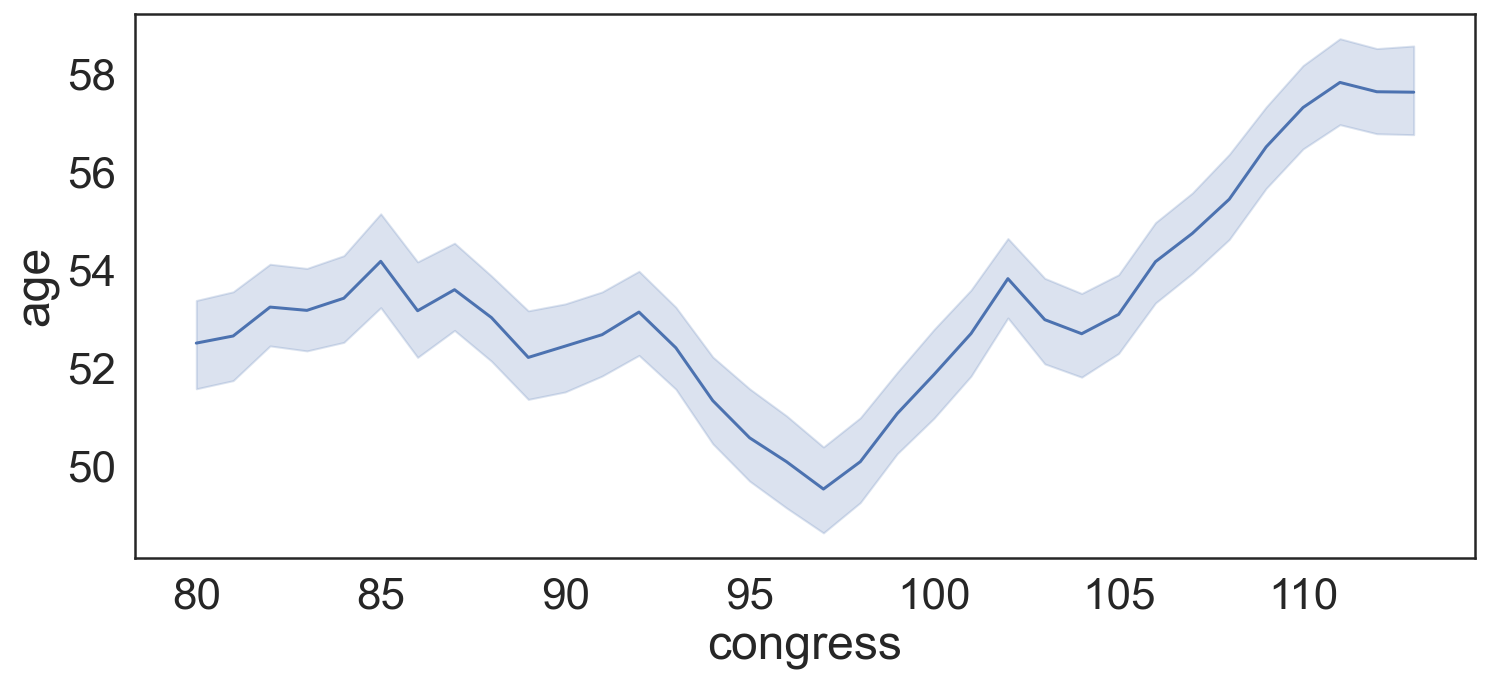

In [27]:
### BEGIN SOLUTION
# general age trend in Congress
# note: you could use fivethirtyeight style since the data came from FiveThirtyEight
# style.use('fivethirtyeight') 
# here we'll just stick to the white background
sns.lineplot(x="congress", y="age", data=politics);

# As a general note, the line on the plot is the average, the shaded light blue 
# demonstrates the standard error around the estimate, 
# giving us an idea about variability in the estimates.
### END SOLUTION

The plot you generated should make it clear that average age in Congress has clearly increased in recent years. But, is this driven by one party over another? Let's break this down by party to see. Additionally, we'd rather the years be on the x-axis, rather than the congress, as we have a better understanding of years. To do this, take a look at the `to_datetime()` function from `pandas` and consider how the `'termstart'` Series in the `politics` dataset can be used to extract the year. Assign the year to a new column `'year'` in the politics dataset.

In [28]:
## get year column in there for x-axis
### BEGIN SOLUTION
politics['year'] = pd.to_datetime(politics['termstart']).dt.year
### END SOLUTION

In [29]:
assert politics['year'].max() == 2013

Then, regenerate the lineplot from above, replacing the x-axis originally used (Congress) with the year.

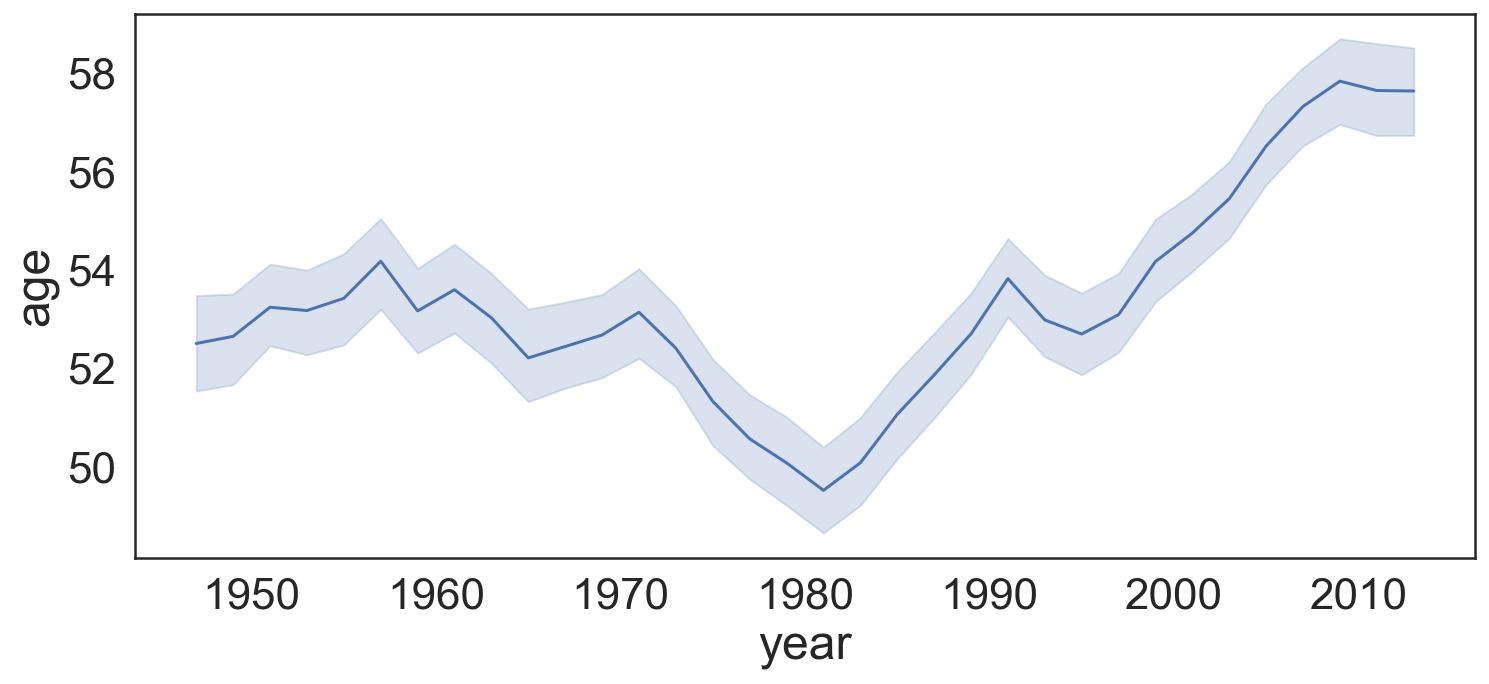

In [30]:
### BEGIN SOLUTION
sns.lineplot(x="year", y="age", data=politics);
### END SOLUTION

Well, what about the same time period for median US population? You can use the `'age'` and `'year'` information from the `age_sub` dataset (as this has the same years as the `politics` dataset).

Remeber that we already have group-level data, so we'll just see a single line, as we don't have information about variability for these data:

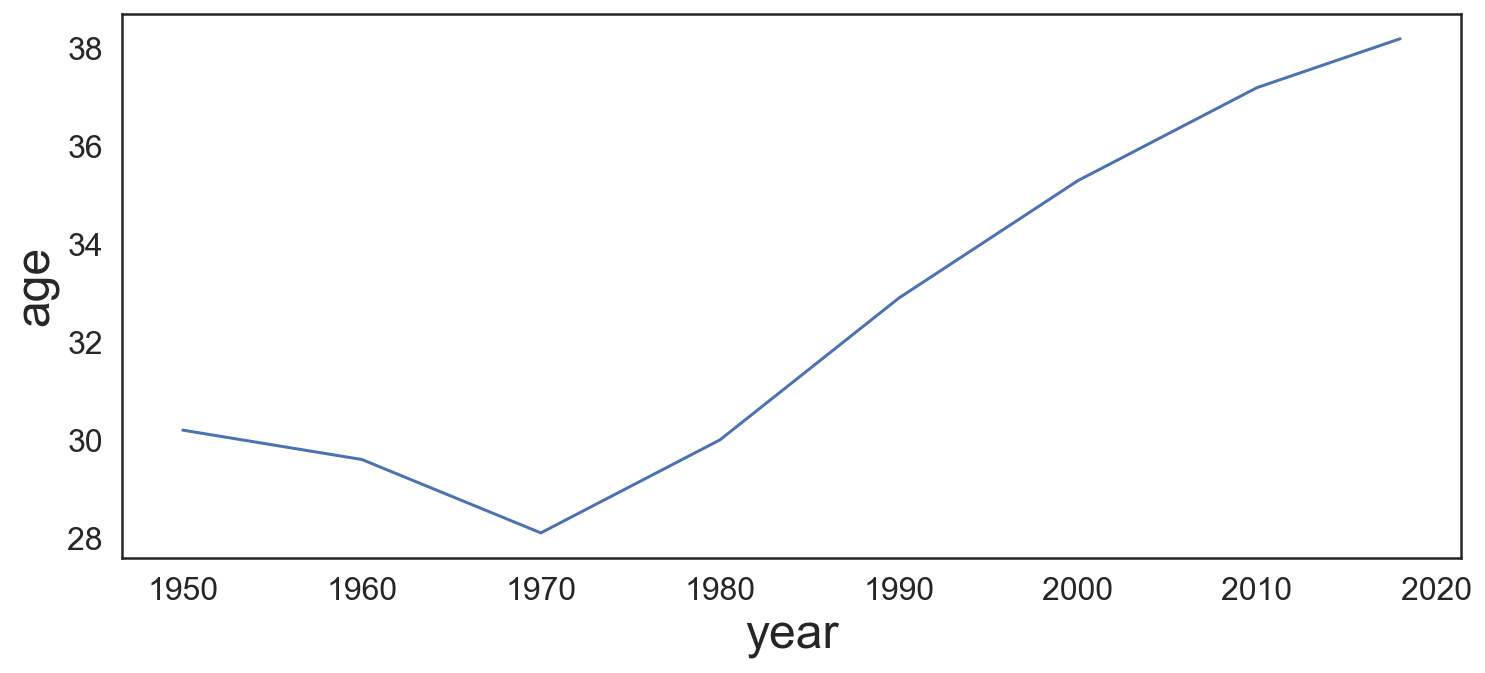

In [31]:
# age trend of US population over time    
### BEGIN SOLUTION
sns.lineplot(x="year", y="age", data=age_sub)
plt.tick_params(labelsize=16);
### END SOLUTION

So, the data also increase overall but we don't see a dip in the 80's like we do above and the increase is pretty steady - certainly less variability than what we saw in the `politics` dataset. Also, the values are different. Here all the median ages are in the 30s, while the average age of Congress members is in the 50s.

This *may* not be the best comparison, due to age limits in Congress. We'd likely want to look at the median age of adults over 25 (for comparison with the House) and over 30 (for comparison with the Senate). You're welcome to go search for those data! For now and the purposes of this workbook, we'll stick with these data!

Having made our initial overall comparison, let's start looking at the breakdowns we were interested in. 

Does age differ by...
- party? 
- chamber?

We'll start by looking at party differences:

Plot the ages in Congress broken down by party.

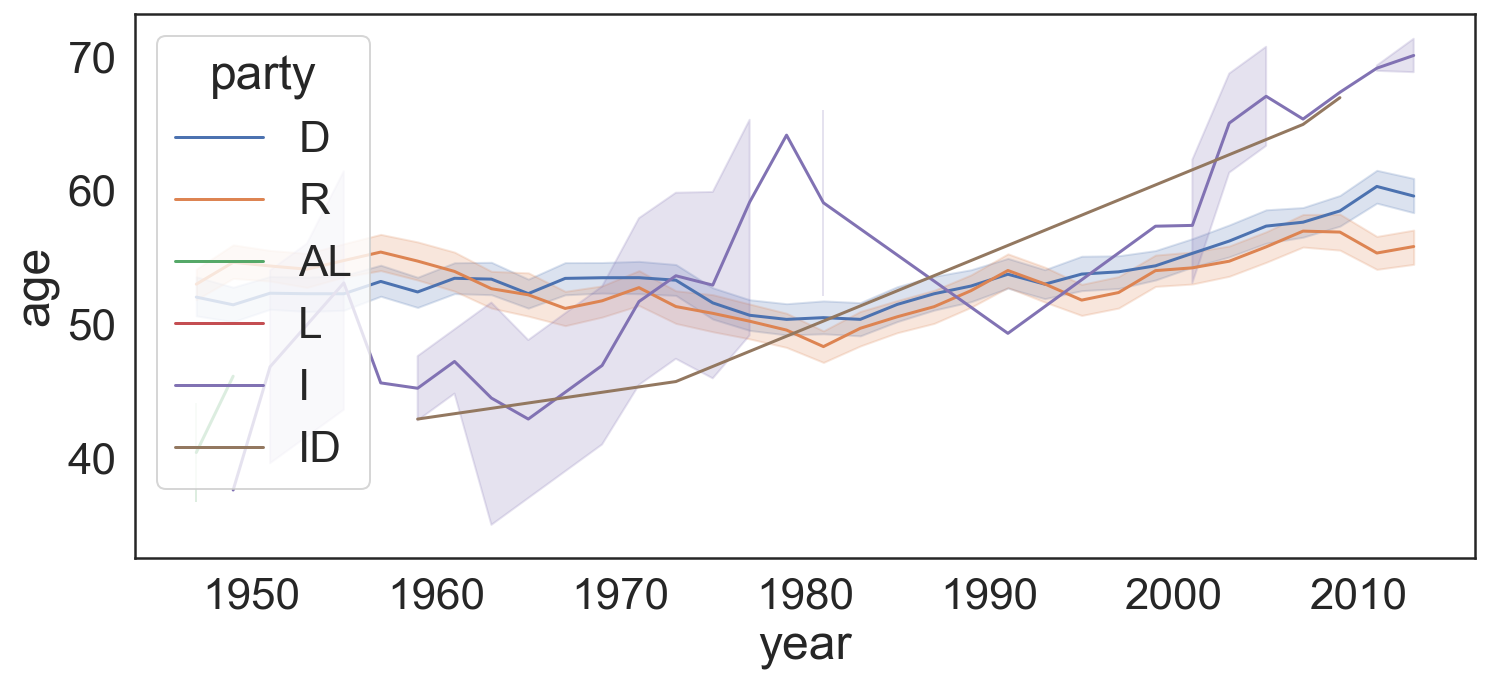

In [32]:
# age trend by party 
### BEGIN SOLUTION
sns.lineplot(x="year", y="age", hue="party",  data=politics);
### END SOLUTION

If you've done this, what you should see here is that while there are individuals in Congress over history from more than the two main parties, these lines represent very few actual individuals (<50 in any given third party...see EDA above). So, for the rest of this analysis, we're just going to focus on the two main parties: Democrats and Repbulicans.

## Filter to only include Democrats and Republicans

Filter your `politics` dataset to only include those members of Congress that belong to either the Democratic Part ('D') or Republican Party ('R'). Store these data in the variable `dem_rep`

In [29]:
### BEGIN SOLUTION
## filter to only include dems and repubs
dem_rep = politics[(politics.party == 'D') | (politics.party == 'R')]
dem_rep.shape
### END SOLUTION

(18564, 14)

In [30]:
assert dem_rep.shape == (18564, 14)

The following color palette is provided, should you want to use red and blue to represent the Republican and Democratic parties, respectively. Feel free to use it, if it helps!

In [31]:
## specify a color pallete
unique = dem_rep["party"].unique()
palette = dict(zip(unique, sns.color_palette(["#0000CD","#ff0000"])))

Go ahead and plot the age trend over time broken down by party using hte `dem_rep` dataset! 

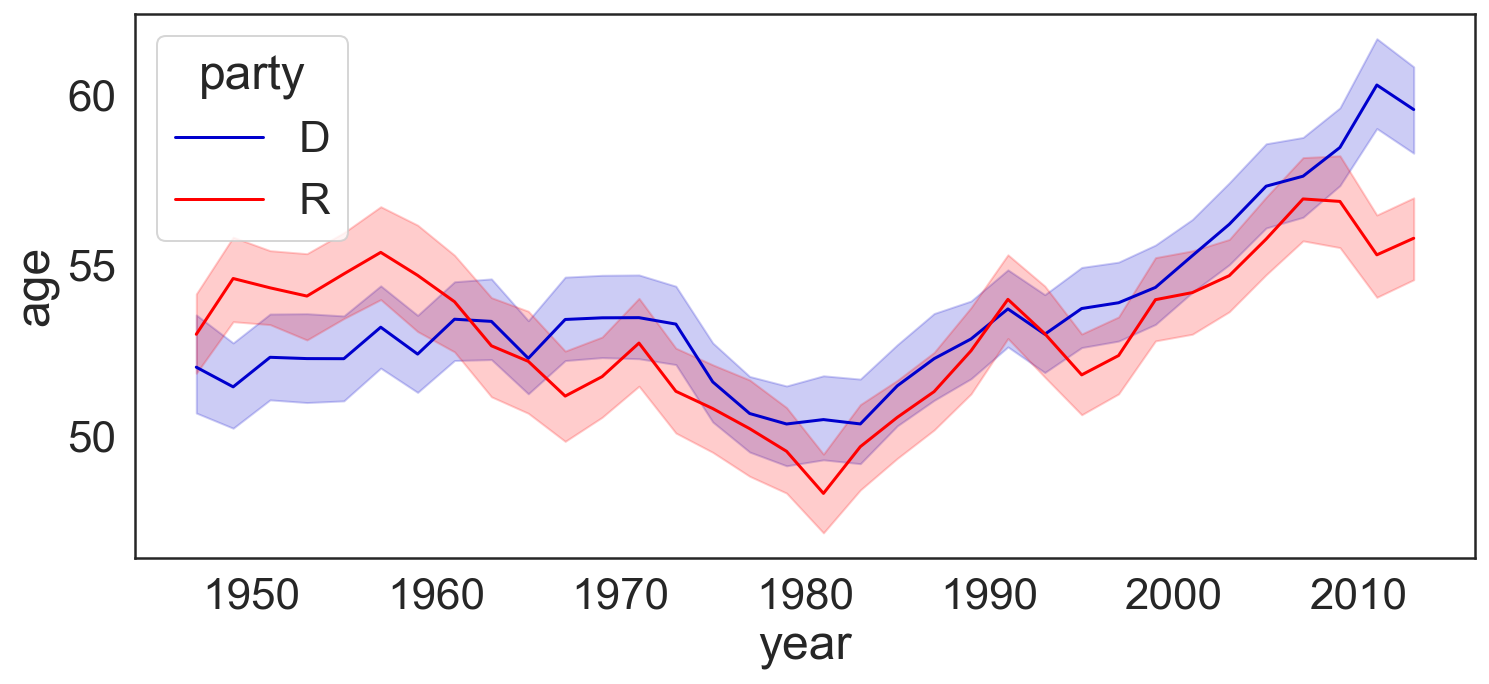

In [32]:
# age trend by party 
### BEGIN SOLUTION
sns.lineplot(x = "year", 
             y = "age", 
             hue = "party",  
             data = dem_rep,
             palette = palette);
### END SOLUTION

After filtering to the two main parties, you shoul see that age is increasing in both parties, following the general overall trend. We note, however, that since the mid-1960s, Democrats in Congress have been being older, on average, than Republicans. We note that 1990 appeared to show a slight reversal in this trend, but with a spike in age overall.

## Does this trend differ by chamber?

Generate a plot to see if this trend looks the same in both chambers of Congress.

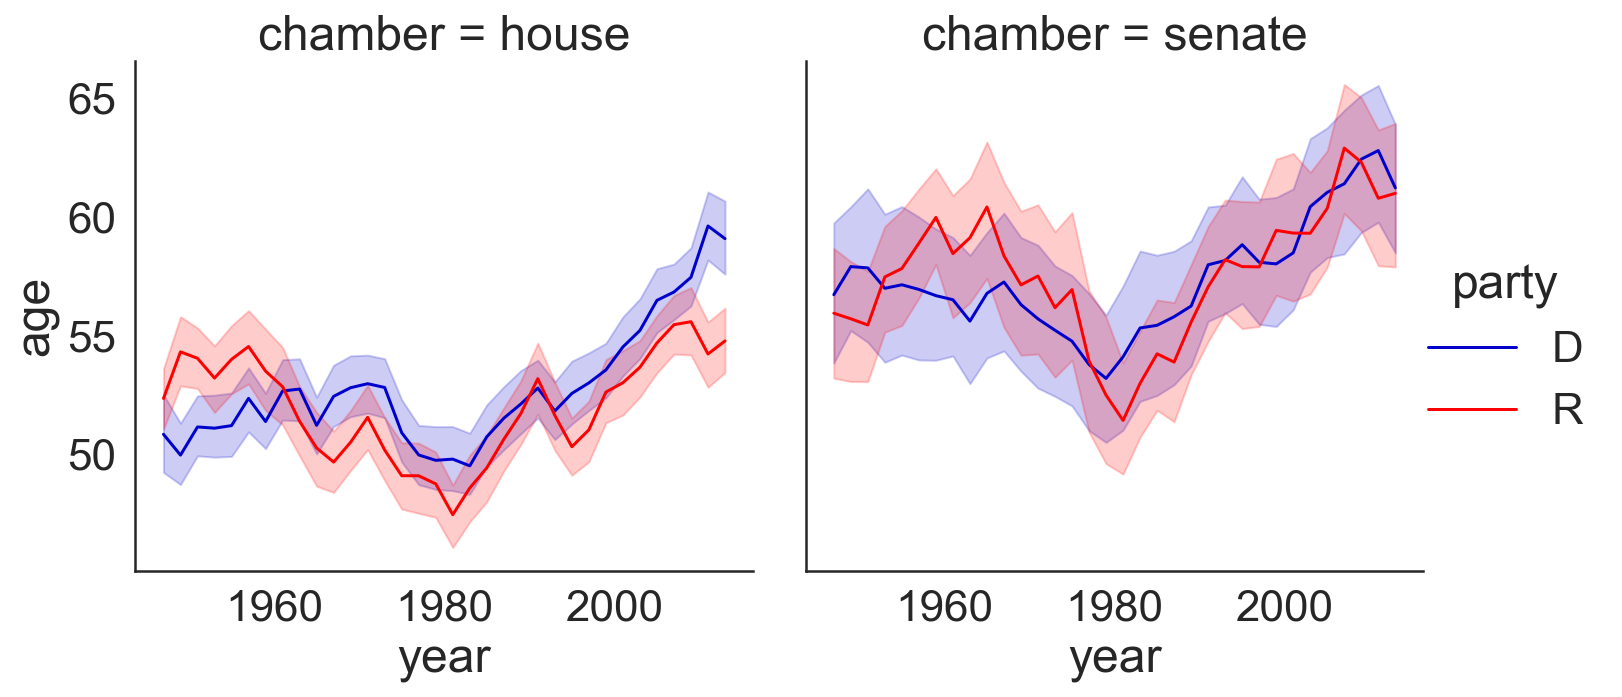

In [33]:
### BEGIN SOLUTION
sns.relplot(x = "year", 
             y = "age", 
             hue = "party",
             col = 'chamber',
             kind = "line",
             data = dem_rep, 
             palette = palette);
### END SOLUTION

When we break this down further by chamber of congress, what you should see is that the separation between Democrats and Republicans is largely driven by age differences in the House. Age in the Senate does not appear to be different between parties (except for in the 1960s). The overall increase in age over recent history, however, is seen in both houses. Note that the age spike in 1990 in the House is not seen in the Senate.

## Effect of Incumbents?

We know that people often spend multiple terms in Congress. Here, we look to see if this trend in age and party is driven by incumbents. To determine this, we filter to a dataset that only includes non-incumbents. This dataset should include 2920 individuals (of the original 15K). Filter your data below to only include non-incumbents. Store this in the dataframe `new_members`.

In [34]:
#just include non-incumbents
### BEGIN SOLUTION
new_members = dem_rep[(dem_rep.incumbent == 'No')]
### END SOLUTION


In [35]:
assert new_members.shape == (2920, 14)

We've again provided a color pallete for this dataset. Feel free to use if helpful!

In [36]:
## specify a color pallete
unique = new_members["party"].unique()
palette = dict(zip(unique, sns.color_palette(["#0000CD","#ff0000"])))

Using the `new_members` dataset, plot age for Congress over time.

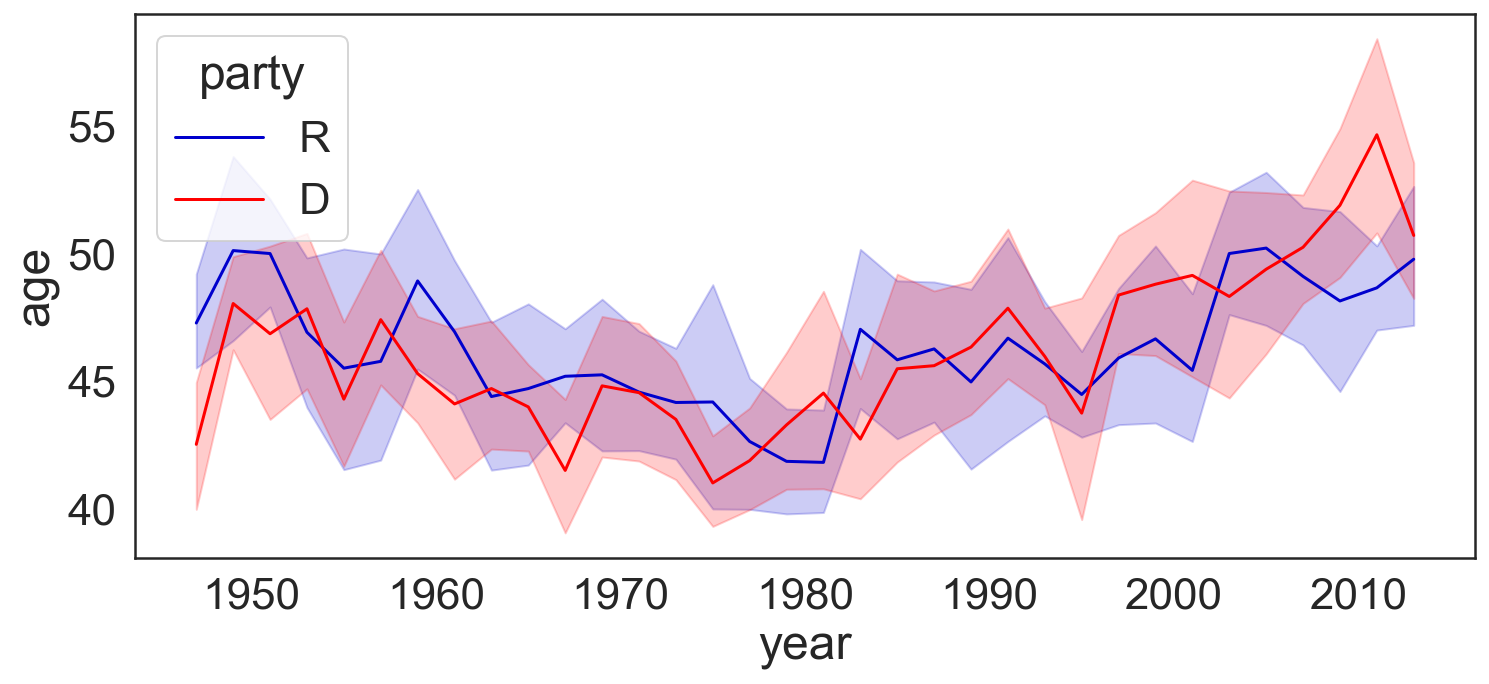

In [37]:
### BEGIN SOLUTION
sns.lineplot(x = "year", 
             y = "age", 
             hue = "party",  
             data = new_members, 
             palette = palette);
### END SOLUTION

Taking a look at this age trend over time. How does it differ from what we saw earlier? Does Congress have an age problem? Incldue your interpretation and answer below:

# Part III: More data? (*optional*)

Once you have a good handle on what's going on in the datasets above, how can you get the data you need to include recent elections? I'll note that in the FiveThirtyEight piece where these data came from, they mention using the NYT's Congress API. However, this has moved to Propublica since publication of that piece: https://projects.propublica.org/api-docs/congress-api/.

This will require you to read API documentation and understand it. You'll need an API Key to run the code below. 

Additionally, you will likely need additional packages (see below). 

Feel free to run the code you see here, change it, and even update it.

In [38]:
# and change the package name if needed
# !pip install pandas_ply 
# if on datahub
# !pip install --user pandas_ply 
# restart kernel after install 
# be sure to reimport pandas from above
from pandas_ply import install_ply, X
install_ply(pd)
import requests
import json

In [42]:
## add Propublica API Key here
key = "YOUR API KEY HERE"

In [43]:
## write functions to help get the data we'll need
## code modified from https://github.com/eyeseast/propublica-congress
def get_data(url):
    """get the data from Propublica API"""
    response = requests.get(url, headers={"X-API-KEY":key})
    return response

def print_data(data, termstart):
    """process the API request from Propublica API"""
    r = json.loads(data.content)

    congress = r['results'][0]['congress']
    chamber = r['results'][0]['chamber']
    df = (pd.DataFrame.from_dict(pd.json_normalize(r['results'][0]['members']), 
                                orient='columns').
          ply_select('first_name',
                     'middle_name',
                     'last_name',
                     'suffix',
                     'date_of_birth',
                     'state',
                     'party',
                     ).
          rename(columns={'date_of_birth':'dob',
                          'first_name':'firstname',
                          'middle_name':'middlename',
                          'last_name': 'lastname'})
                   )
    df['congress'] = congress.lower()
    df['chamber'] = chamber.lower()
    df['termstart'] = termstart
    df['age'] = pd.to_datetime(df['termstart']).dt.year - pd.to_datetime(df['dob']).dt.year
    df['year'] = pd.to_datetime(df['termstart']).dt.year
    return df

def get_df(termstart, url):
    """combine functions to get dataframe with the information we want"""
    a = get_data(url)
    out = print_data(a, termstart=termstart)
    return out

Using the functions we just defined, we can get a dataset for each congress since the data included in our dataset, one from the seante and one from the house. We can then merge them together.

In [44]:
## get updated data for years since FiveThirtyEight was collected
## note: this code could be programmatically cleaned up (but Professor Ellis was being super lazy)
## certainly let Professor Ellis know if you approached this differently and in a more straightforward way

#114
senate_114 = get_df(termstart = '2015-01-03', url = "https://api.propublica.org/congress/v1/114/senate/members.json")
house_114 = get_df(termstart = '2015-01-03', url = "https://api.propublica.org/congress/v1/114/house/members.json")

#115
senate_115 = get_df(termstart = '2017-01-03', url = "https://api.propublica.org/congress/v1/115/senate/members.json")
house_115 = get_df(termstart = '2017-01-03', url = "https://api.propublica.org/congress/v1/115/house/members.json")

#116
senate_116 = get_df(termstart = '2019-01-03', url = "https://api.propublica.org/congress/v1/116/senate/members.json")
house_116 = get_df(termstart = '2019-01-03', url = "https://api.propublica.org/congress/v1/116/house/members.json")

#116
senate_117 = get_df(termstart = '2021-01-03', url = "https://api.propublica.org/congress/v1/117/senate/members.json")
house_117 = get_df(termstart = '2021-01-03', url = "https://api.propublica.org/congress/v1/117/house/members.json")

# combine and filter
new_data = pd.concat([senate_114, house_114, senate_115, house_115, senate_116, house_116, senate_117, house_117])
new_data = new_data[(new_data.party == 'D') | (new_data.party == 'R')]

In [45]:
df1 = dem_rep[['year', 'chamber', 'age', 'party']]
df2 = new_data[['year', 'chamber', 'age', 'party']]

politics_updated = pd.concat([df1, df2])

With our updated data, let's take a look at the data and trend on a similar plot again!

In [46]:
## most recent trends...
politics_updated.groupby(['year', 'party']).agg({'age':'mean'}).tail(8)

age
year party           
2015 D      60.920502
     R      56.403909
2017 D      61.226190
     R      57.654723
2019 D      59.505226
     R      58.167939
2021 D      60.909091
     R      58.251880

In [47]:
## specify a color pallete
unique = politics_updated["party"].unique()
palette = dict(zip(unique, sns.color_palette(["#0000CD", "#ff0000"])))

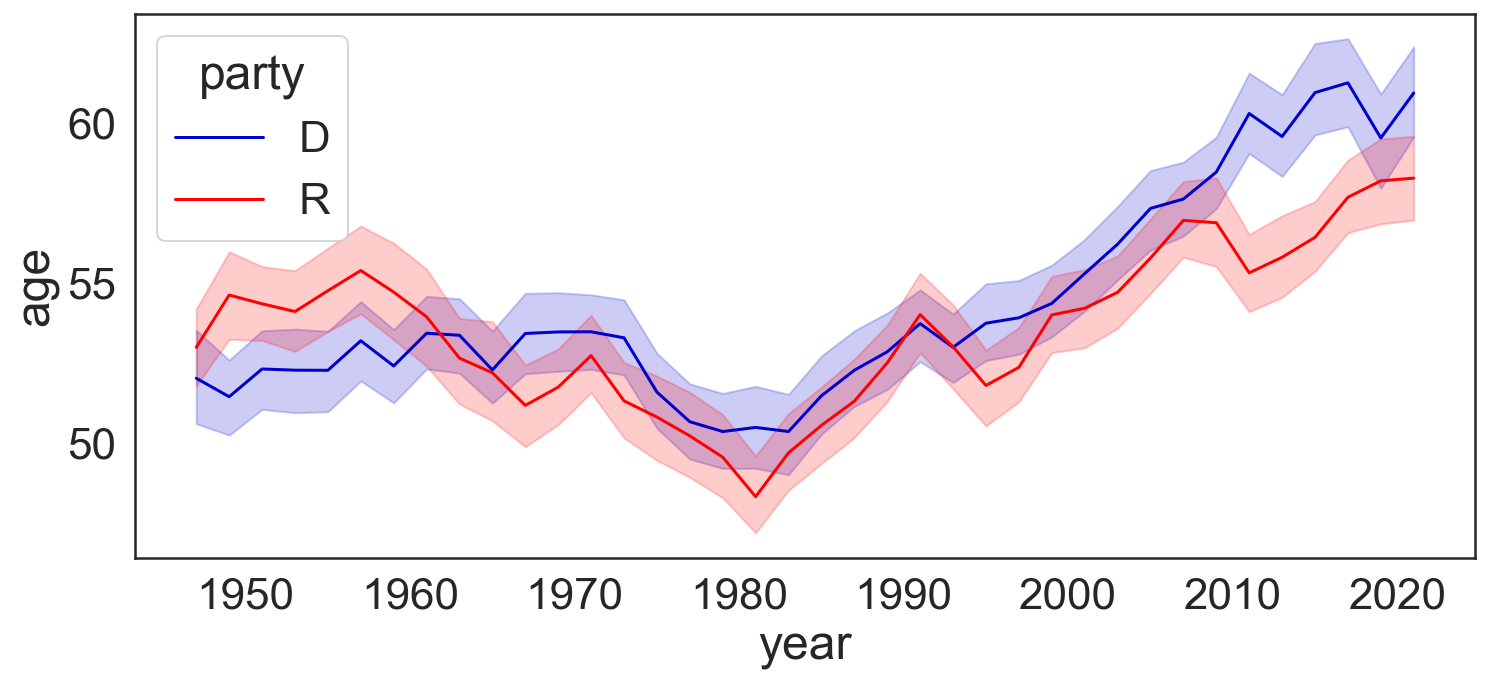

In [48]:
sns.lineplot(x = "year", 
             y = "age", 
             hue = "party",  
             data = politics_updated, 
             palette = palette);

Looks like the age for the Demcrats were on a downward trend but reversed course in the most recent elections and are and have been higher than the Republicans. Will be interesting to see what happens in coming elections!

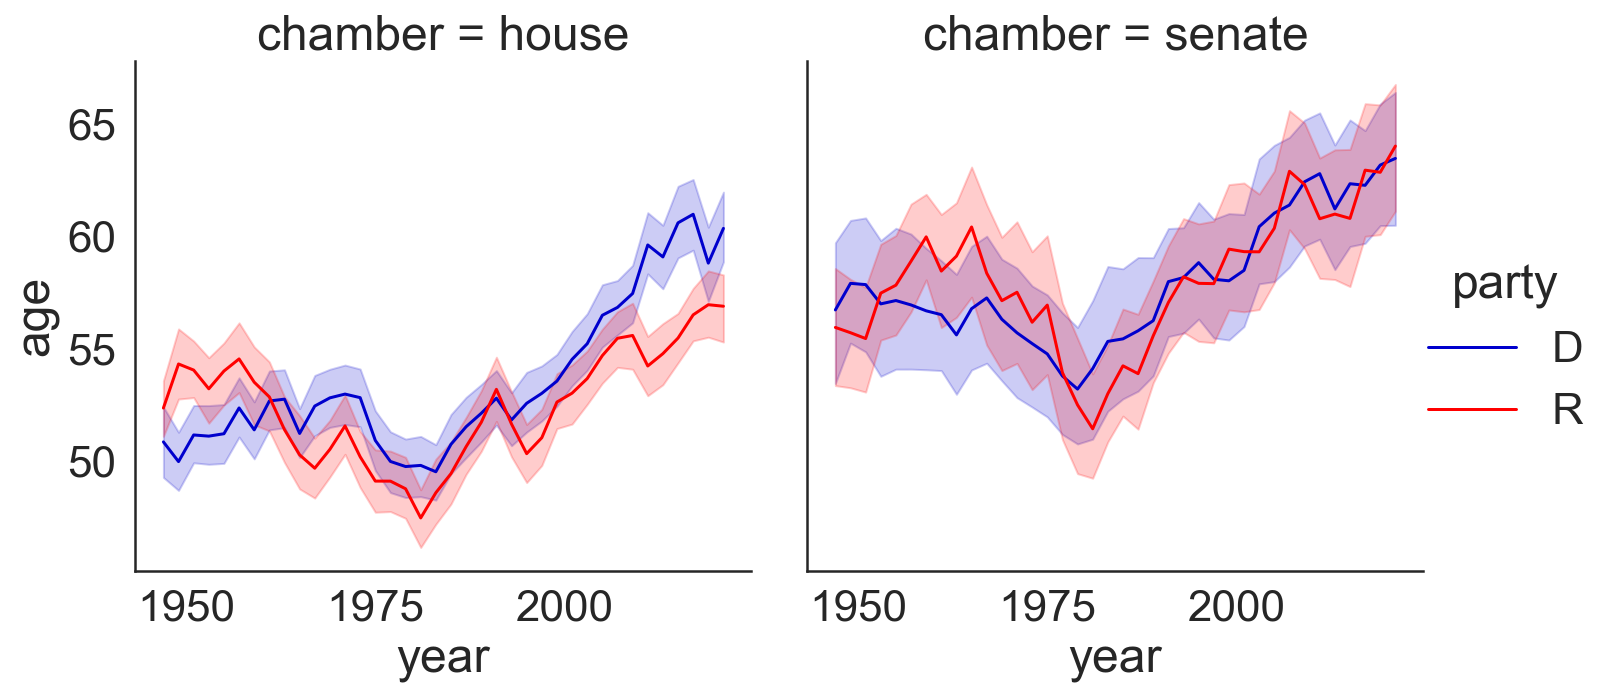

In [49]:
sns.relplot(x = "year", 
            y = "age", 
            hue = "party",
            col = 'chamber',
            kind = "line",
            data = politics_updated, 
            palette = palette); 

Finally (after lots of data acquisition and exploration), we see that this downward trend is still driven by age in the House for Democrats. Let's see what happens in the future!